#### Aug. 10, 2018 320pm

In [1]:
import numpy   as np
import pandas  as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from nltk.corpus import stopwords

import re

---

### Large Pickled Dataset



In [2]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 784 ms, sys: 564 ms, total: 1.35 s
Wall time: 1.8 s


In [3]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 72 ms, sys: 48 ms, total: 120 ms
Wall time: 232 ms


In [4]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923002 entries, 0 to 923001
Data columns (total 17 columns):
business_id    923002 non-null object
name           923002 non-null object
review_id      923002 non-null object
stars          923002 non-null int64
date           923002 non-null datetime64[ns]
text           923002 non-null object
useful         923002 non-null int64
funny          923002 non-null int64
cool           923002 non-null int64
city           923002 non-null object
state          923002 non-null object
Thai           923002 non-null float64
Italian        923002 non-null float64
Indian         923002 non-null float64
Chinese        923002 non-null float64
Mexican        923002 non-null float64
Text_length    923002 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 119.7+ MB


In [5]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 17.1 s, sys: 136 ms, total: 17.3 s
Wall time: 18.9 s


In [6]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 740 ms, sys: 0 ns, total: 740 ms
Wall time: 1.02 s


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [8]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [9]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])

In [10]:
vectorizer = TfidfVectorizer(stop_words=stopWords)

#### Vectorize Review Text

In [11]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 46.5 s, sys: 628 ms, total: 47.1 s
Wall time: 53 s


In [12]:
X_train_term.shape

(646101, 140970)

In [13]:
ftrs = vectorizer.get_feature_names()

In [14]:
ftrs

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg',
 'aaaaaaaaaaaaaand',
 'aaaaaaaaaaaaaauthentic',
 'aaaaaaaaaaaand',
 'aaaaaaaaaaack',
 'aaaaaaaaaah',
 'aaaaaaaaaand',
 'aaaaaaaaargh',
 'aaaaaaaack',
 'aaaaaaaamazing',
 'aaaaaaaawesooooooooooooome',
 'aaaaaaah',
 'aaaaaaahhhhhh',
 'aaaaaaamazing',
 'aaaaaaammmmazing',
 'aaaaaaand',
 'aaaaaaggghhh',
 'aaaaaah',
 'aaaaaahhhhh',
 'aaaaaahhhhhmazing',
 'aaaaaamazing',
 'aaaaaand',
 'aaaaaannnndddd',
 'aaaaaawesome',
 'aaaaagh',
 'aaaaah',
 'aaaaahhh',
 'aaaaahhhhhhmazing',
 'aaaaahhhhmaaazeballs',
 'aaaaamazing',
 'aaaaammmaazzzinnngg',
 'aaaaand',
 'aaaaawful',
 'aaaaay',
 'aaaack',
 'aaaagh',
 'aaaah',
 'aaaahh',
 'aaaahhh',
 'aaaahhhh',
 'aaaahhhhhhs',
 'aaaahmazzzing',
 'aaaajúa',
 'aaaalllllllll',
 'aaaallright',
 'aaaamaaazing',
 'aaaamazing',
 'aaaamazzzzing',
 'aaaammaaazzziiingggg',
 'aaaammazzing',
 'aaaammmazziiigggg',
 'aaaammmmmmazing',
 'aaaamzing',
 

---

#### Mutlinomial NB - Train

In [ ]:
>>> clf = GaussianNB()
>>> clf.fit(X, Y)
GaussianNB(priors=None)
>>> print(clf.predict([[-0.8, -1]]))
[1]
>>> clf_pf = GaussianNB()
>>> clf_pf.partial_fit(X, Y, np.unique(Y))
GaussianNB(priors=None)
>>> print(clf_pf.predict([[-0.8, -1]]))

In [15]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


In [17]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 312 ms, sys: 16 ms, total: 328 ms
Wall time: 646 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [18]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 20.4 s, sys: 132 ms, total: 20.5 s
Wall time: 27 s


In [19]:
X_test_term.shape

(276901, 140970)

In [20]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 177 ms


In [21]:
len(pred)

276901

In [22]:
pred[:30]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
np.unique(pred)

array([0., 1.])

In [24]:
y_test[:10]

608724    1.0
473159    0.0
789863    0.0
791257    0.0
326030    0.0
242723    1.0
653320    0.0
309784    0.0
117409    0.0
362256    1.0
Name: vegFriendly, dtype: float64

In [25]:
pred[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [27]:
lbls = ['vegFriendly', 'Non-vegFriendly']

cm = confusion_matrix(y_test, pred)
cm

array([[218943,   1397],
       [ 43837,  12724]])

In [28]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.83      0.99      0.91    220340
        1.0       0.90      0.22      0.36     56561

avg / total       0.85      0.84      0.79    276901



In [29]:
accuracy_score(y_test, pred)

0.8366419767353676

In [30]:
precision_score(y_test, pred)

0.9010693293676085

In [31]:
recall_score(y_test, pred)

0.22496066194020614

In [32]:
f1_score(y_test, pred)

0.360035086726465

Confusion matrix, without normalization


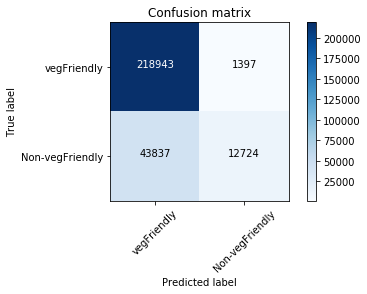

In [36]:
plot_confusion_matrix(cm,lbls)

In [41]:
y_score = M_NB_model.predict_proba(X_test_term)[:,1]

In [42]:
y_score[:10]

array([0.2375639 , 0.01452686, 0.20183143, 0.08411144, 0.044017  ,
       0.17490146, 0.07130041, 0.03327107, 0.17920261, 0.2273582 ])

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)

AUC score: 0.8567253478612689


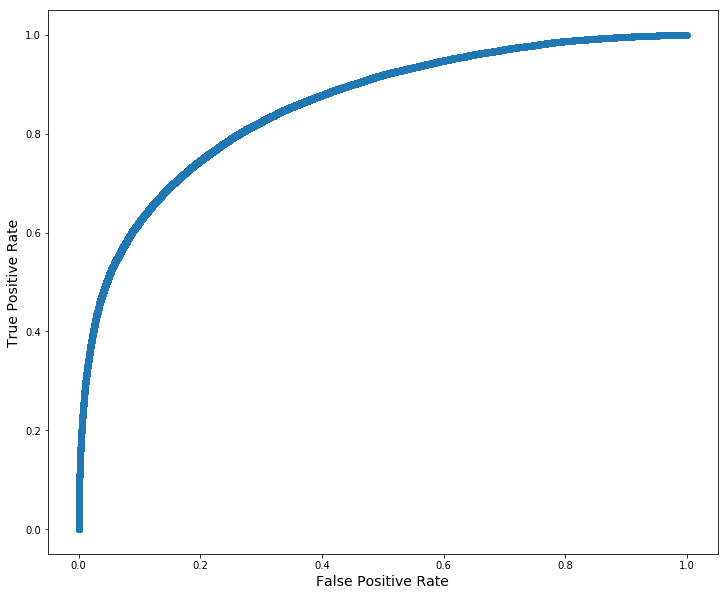

In [52]:
plt.figure(figsize=(12,10))
plt.plot(fpr, tpr, 'o--')
plt.ylabel("True Positive Rate",  fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14);
print("AUC score:", roc_auc_score(y_test, y_score))

In [38]:
importances = M_NB_model.feature_importances_

importances

AttributeError: 'MultinomialNB' object has no attribute 'feature_importances_'

In [35]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')